In [1]:
!ln -s /usr/local/cuda-11.1/targets/x86_64-linux/lib/libcusolver.so.11.0.1.105 /usr/local/cuda-11.1/targets/x86_64-linux/lib/libcusolver.so.10

ln: failed to create symbolic link '/usr/local/cuda-11.1/targets/x86_64-linux/lib/libcusolver.so.10': File exists


In [2]:
import pathlib

In [3]:
import tensorflow as tf

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
#data_dir = pathlib.Path("/home/cdsw/chest_xray_pneumonia")
data_dir = pathlib.Path("/home/cdsw/chest_xray")

In [6]:
batch_size = 32
img_height = 600 #600
img_width = 600 #600
IMG_SIZE = 456
#IMG_SIZE = (224, 224)

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 5616 files belonging to 2 classes.
Using 4493 files for training.


In [8]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 5616 files belonging to 2 classes.
Using 1123 files for validation.


In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

### Data augmentation

We can use preprocessing layers APIs for image augmentation.

In [10]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.1),
        preprocessing.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        preprocessing.RandomZoom(0.1),
    ],
    name="img_augmentation",
)  

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [12]:
# from tensorflow.keras.applications import EfficientNetB5

# inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = img_augmentation(inputs)
# outputs = EfficientNetB5(include_top=True, weights=None)(x) #, classes=NUM_CLASSES)
# outputs = tf.keras.layers.Dense(1)(outputs)

# model = tf.keras.Model(inputs, outputs)
# model.compile(
#     optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
# )

In [13]:
# len(model.trainable_variables)

In [14]:
# model.summary()

In [15]:
# epochs = 5  # @param {type: "slider", min:10, max:100}
# hist = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

In [16]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

Training the model is relatively fast (takes only 20 seconds per epoch on TPUv2 that is
available on Colab). This might make it sounds easy to simply train EfficientNet on any
dataset wanted from scratch. However, training EfficientNet on smaller datasets,
especially those with lower resolution like CIFAR-100, faces the significant challenge of
overfitting.

Hence training from scratch requires very careful choice of hyperparameters andtrain_datasetult to find suitable regularization. It would also be much more demanding in resources.
Plotting the training and validation accuracy
makes it clear that validation accuracy stagnates at a low value.

In [17]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim([0,1])
    plt.show()


#

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [19]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB5

#def build_model(num_classes):
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
model = EfficientNetB5(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#x = effientnet_model(x)
outputs = layers.Dense(1, name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)


In [20]:
#model.summary()

The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.
If image augmentation layers were not
applied, the validation accuracy may only reach ~60%.

In [21]:
#epochs = 10  # @param {type: "slider", min:8, max:80}
#hist = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

In [22]:
#loss, accuracy = model.evaluate(test_dataset)
#print('Test accuracy :', accuracy)

In [23]:
#plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. Such a situation can be demonstrated
if choosing CIFAR-100 dataset instead, where fine-tuning boosts validation accuracy
by about 10% to pass 80% on `EfficientNetB0`.
In such a case the convergence may take more than 50 epochs.

A side note on freezing/unfreezing models: setting `trainable` of a `Model` will
simultaneously set all layers belonging to the `Model` to the same `trainable`
attribute. Each layer is trainable only if both the layer itself and the model
containing it are trainable. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `trainable` attribute of the model is set
to `True`.

In [24]:
len(model.trainable_variables)

4

In [25]:
for i, layer in enumerate(model.layers):
  if i > len(model.layers) - 21:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
  else:
    layer.trainable = False

    
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

In [26]:
len(model.trainable_variables)

11

In [27]:
epochs = 30  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/30
141/141 [==============================] - 506s 3s/step - loss: 4.2494 - accuracy: 0.7047 - val_loss: 7.1958 - val_accuracy: 0.5139
Epoch 2/30
141/141 [==============================] - 328s 2s/step - loss: 3.0599 - accuracy: 0.7955 - val_loss: 6.7447 - val_accuracy: 0.5551
Epoch 3/30
141/141 [==============================] - 328s 2s/step - loss: 4.2863 - accuracy: 0.7183 - val_loss: 1.7228 - val_accuracy: 0.8843
Epoch 4/30
141/141 [==============================] - 328s 2s/step - loss: 4.2840 - accuracy: 0.7162 - val_loss: 3.7951 - val_accuracy: 0.7253
Epoch 5/30
141/141 [==============================] - 328s 2s/step - loss: 4.2270 - accuracy: 0.7133 - val_loss: 3.7941 - val_accuracy: 0.7442
Epoch 6/30
141/141 [==============================] - 329s 2s/step - loss: 2.7848 - accuracy: 0.8119 - val_loss: 4.2146 - val_accuracy: 0.7197
Epoch 7/30
141/141 [==============================] - 329s 2s/step - loss: 3.1072 - accuracy: 0.7921 - val_loss: 3.2572 - val_accuracy: 0.7864

In [28]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 17s 2s/step - loss: 6.0555 - accuracy: 0.5848
Test accuracy : 0.5848214030265808


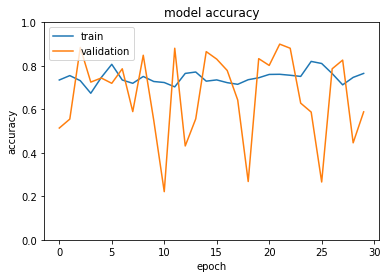

In [29]:
plot_hist(hist)

### Tips for fine tuning EfficientNet

On unfreezing layers:

- The `BathcNormalization` layers need to be kept frozen
([more details](https://keras.io/guides/transfer_learning/)).
If they are also turned to trainable, the
first epoch after unfreezing will significantly reduce accuracy.
- In some cases it may be beneficial to open up only a portion of layers instead of
unfreezing all. This will make fine tuning much faster when going to larger models like
B7.
- Each block needs to be all turned on or off. This is because the architecture includes
a shortcut from the first layer to the last layer for each block. Not respecting blocks
also significantly harms the final performance.

Some other tips for utilizing EfficientNet:

- Larger variants of EfficientNet do not guarantee improved performance, especially for
tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet
chosen, the harder it is to tune hyperparameters.
- EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch,
but not so much for transfer learning.
- Do not use the RMSprop setup as in the original paper for transfer learning. The
momentum and learning rate are too high for transfer learning. It will easily corrupt the
pretrained weight and blow up the loss. A quick check is to see if loss (as categorical
cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same
epoch. If so, the initial learning rate/momentum is too high.
- Smaller batch size benefit validation accuracy, possibly due to effectively providing
regularization.

## Using the latest EfficientNet weights

Since the initial paper, the EfficientNet has been improved by various methods for data
preprocessing and for using unlabelled data to enhance learning results. These
improvements are relatively hard and computationally costly to reproduce, and require
extra code; but the weights are readily available in the form of TF checkpoint files. The
model architecture has not changed, so loading the improved checkpoints is possible.

To use a checkpoint provided at
[the official model repository](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), first
download the checkpoint. As example, here we download noisy-student version of B1:

```
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet\
       /noisystudent/noisy_student_efficientnet-b1.tar.gz
!tar -xf noisy_student_efficientnet-b1.tar.gz
```

Then use the script [efficientnet_weight_update_util.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py) to convert ckpt file to h5 file.

```
!python efficientnet_weight_update_util.py --model b1 --notop --ckpt \
        efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5
```

When creating model, use the following to load new weight:

```python
model = EfficientNetB1(weights="efficientnetb1_notop.h5", include_top=False)
```